Копируем бойлерплейт из примера, тут менять нечего

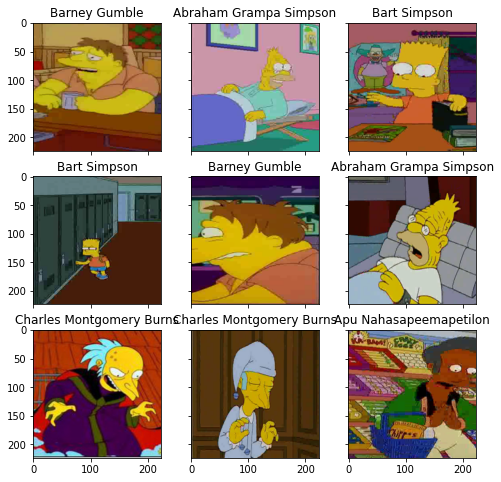

In [65]:
import torch

import pickle
import numpy as np
from skimage import io
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)
val_dataset = SimpsonsDataset(val_files, mode='val')

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(), val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), title=img_label,plt_ax=fig_x)

Нейросеть из примера

In [2]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

Снова бойлерплейт, все тривиально, но писать руками не хочется

In [69]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
    
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [4]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

In [5]:
n_classes = len(np.unique(train_val_labels))
print("we will classify {} classes".format(n_classes))

we will classify 42 classes


In [6]:
# simple_cnn = SimpleCnn(n_classes).to(DEVICE)
# print(simple_cnn)

SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_features=42, bias=True)


In [7]:
# history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

epoch:  50%|█████     | 1/2 [02:21<02:21, 141.93s/it]
Epoch 001 train_loss: 2.5174 val_loss 1.8849 train_acc 0.3103 val_acc 0.4874
loss 1.450798469148963
epoch: 100%|██████████| 2/2 [04:30<00:00, 135.24s/it]
Epoch 002 train_loss: 1.4508 val_loss 1.2124 train_acc 0.6036 val_acc 0.6783



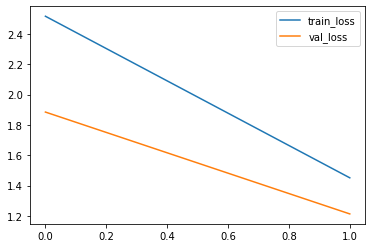

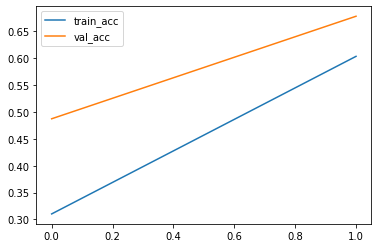

In [11]:
# train_loss, train_acc, val_loss, val_acc = zip(*history)
# plt.plot(train_loss, label='train_loss')
# plt.plot(val_loss, label='val_loss')
# plt.legend(loc='best')
# plt.show()
# plt.plot(train_acc, label='train_acc')
# plt.plot(val_acc, label='val_acc')
# plt.legend(loc='best')
# plt.show()

In [39]:
# random_characters = int(np.random.uniform(0,1000))
# ex_img, true_label = val_dataset[random_characters]
# probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

# idxs = list(map(int, np.random.uniform(0,1000, 20)))
# imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

# probs_ims = predict(simple_cnn, imgs)

# with open('label_encoder.pkl', 'rb') as f:
#     label_encoder = pickle.load(f)

# y_pred = np.argmax(probs_ims,-1)
# actual_labels = [val_dataset[id][1] for id in idxs]
# preds_class = [i for i in y_pred]

# f1_score(actual_labels, preds_class, average=None)

array([0.66666667, 0.8       , 0.        , 0.57142857, 0.33333333,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

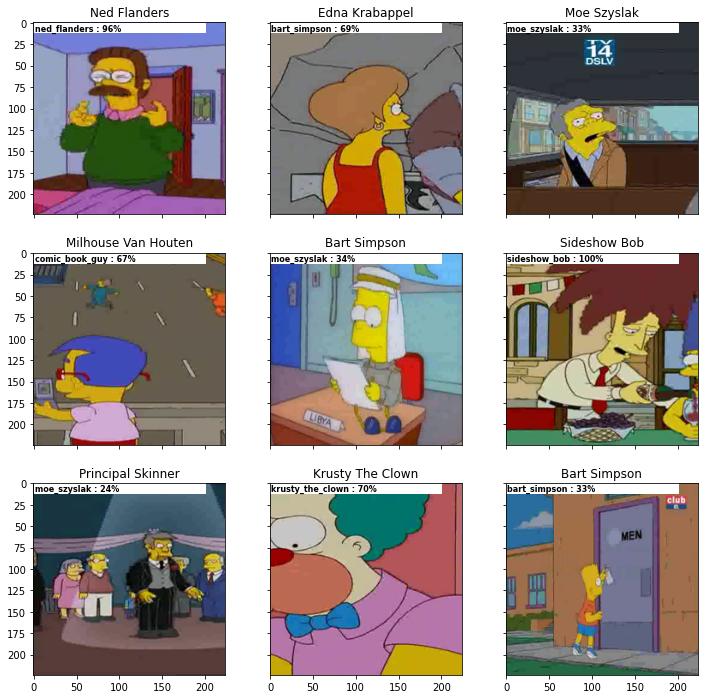

In [38]:
# import matplotlib.patches as patches
# from matplotlib.font_manager import FontProperties

# fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), sharey=True, sharex=True)
# for fig_x in ax.flatten():
#     random_characters = int(np.random.uniform(0, 1000))
#     im_val, label = val_dataset[random_characters]
#     img_label = " ".join(map(lambda x: x.capitalize(), val_dataset.label_encoder.inverse_transform([label])[0].split('_')))

#     imshow(im_val.data.cpu(), title=img_label,plt_ax=fig_x)
    
#     actual_text = "Actual : {}".format(img_label)

#     fig_x.add_patch(patches.Rectangle((0, 0), 200, 11, color='white'))
#     prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
#     predicted_proba = np.max(prob_pred) * 100
#     y_pred = np.argmax(prob_pred)
    
#     predicted_label = label_encoder.classes_[y_pred]
#     predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
#     fig_x.text(1, 1, predicted_text, horizontalalignment='left',
#             verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [52]:
from torchvision import models
alexnet = models.alexnet(pretrained=True).to(DEVICE)
alexnet.classifier[6] = nn.Linear(4096, n_classes).to(DEVICE)
for param in alexnet.features[:-5].parameters():
    param.requires_grad = False
history = train(train_dataset, val_dataset, model=alexnet, epochs=20, batch_size=256)

epoch:   5%|▌         | 1/20 [02:06<40:03, 126.48s/it]
Epoch 001 train_loss: 1.3095 val_loss 0.5871 train_acc 0.6639 val_acc 0.8493
loss 0.33344852717805573
epoch:  10%|█         | 2/20 [04:13<37:59, 126.65s/it]
Epoch 002 train_loss: 0.3334 val_loss 0.4638 train_acc 0.9109 val_acc 0.8793
loss 0.10983680013342491
epoch:  15%|█▌        | 3/20 [06:20<35:56, 126.84s/it]
Epoch 003 train_loss: 0.1098 val_loss 0.5239 train_acc 0.9685 val_acc 0.8846
loss 0.07105979832645412
epoch:  20%|██        | 4/20 [08:32<34:10, 128.19s/it]
Epoch 004 train_loss: 0.0711 val_loss 0.5277 train_acc 0.9806 val_acc 0.8875
loss 0.06097486817356097
epoch:  25%|██▌       | 5/20 [10:46<32:29, 129.96s/it]
Epoch 005 train_loss: 0.0610 val_loss 0.5546 train_acc 0.9841 val_acc 0.8909
loss 0.09865739814869723
epoch:  30%|███       | 6/20 [12:57<30:26, 130.49s/it]
Epoch 006 train_loss: 0.0987 val_loss 0.5238 train_acc 0.9725 val_acc 0.8945
loss 0.06229079629734934
epoch:  35%|███▌      | 7/20 [15:10<28:23, 131.02s/it]
Epo

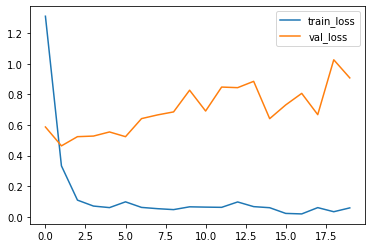

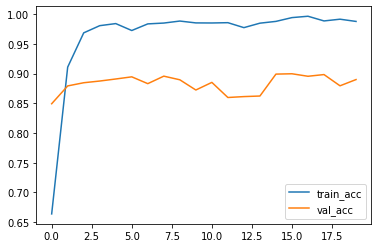

In [53]:
train_loss, train_acc, val_loss, val_acc = zip(*history)
plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.legend(loc='best')
plt.show()
plt.plot(train_acc, label='train_acc')
plt.plot(val_acc, label='val_acc')
plt.legend(loc='best')
plt.show()

In [70]:
test_dataset = SimpsonsDataset(test_files, 'test')
predictions = predict(alexnet, DataLoader(test_dataset, batch_size=256))

In [77]:
pred_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))
filenames = [path.name for path in test_dataset.files]

import pandas as pd
df = pd.DataFrame({'Id': filenames, 'Expected': pred_labels})
df.to_csv('submission.csv', index=None)